In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
from joblib import Parallel, delayed
import arviz as az   
import networkx as nx
from scipy.spatial import distance

import matplotlib.cm as cm
import matplotlib.colors as mcolors

from sklearn.preprocessing import MinMaxScaler



In [2]:
#! conda run pip install networkx

In [2]:
def break_even_cost(profile, cost_var="ccSolve_signlogCost", post=None, model_path="signlogCost_full.nc"):
    """
    Computes break-even cost for a given profile using a stored posterior model.

    Parameters
    ----------
    profile : dict
        Dictionary of covariate names and their values (must match model names).
    cost_var : str
        Name of the variable for cost sensitivity.
    post : xarray.Dataset or None
        Posterior samples. If None, loads from model_path.
    model_path : str
        Path to the .nc file to load if post is not given.

    Returns
    -------
    pd.DataFrame
        DataFrame with one column 'cost_star' and posterior draws.
    """
    if post is None:
        post = az.from_netcdf(model_path).posterior

    # Parameters
    beta_cost = post[cost_var]
    thresholds = post["threshold"]
    alpha1 = thresholds.sel(threshold_dim=1)
    alpha2 = thresholds.sel(threshold_dim=2)
    eta_target = 0.5 * (alpha1 + alpha2)

    # Fixed component
    eta_fixed = 0
    for name, value in profile.items():
        if name in post.data_vars:
            eta_fixed += post[name] * value

    signlog_cost_star = (eta_target - eta_fixed) / beta_cost
    cost_star = np.sign(signlog_cost_star) * (np.exp(np.abs(signlog_cost_star))-1)

    return cost_star.to_dataframe(name="cost_star").reset_index()

In [3]:
with open('df_ccsolve_analysis.pkl', 'rb') as f:
    df = pickle.load(f)

In [4]:
print(df.columns)

Index(['dem_male', 'dem_educ', 'dem_age', 'dem_race', 'dem_latino',
       'dem_income', 'pol_party', 'pol_lean', 'dem_stcount_1', 'WAVE',
       'pol_score', 'log_income_median', 'educ_adv', 'dem_male_simp',
       'high_income', 'ccSolve_support_givenCost', 'ccSolve_cost',
       'ccSolve_signlogCost'],
      dtype='object')


In [5]:
df['high_income'] = df['high_income'].astype('int')
df['dem_male_simp'] = df['dem_male_simp'].map({False: 0,  True:1}).astype('int')
df['educ_adv'] = df['educ_adv'].map({False: 0,  True:1}).astype('int')


In [6]:
# Get distributions of all columns in the dataframe, handling numeric, boolean, and categorical/object types
columns_to_check = ['high_income','pol_score','dem_male_simp','dem_age','educ_adv']
for col in columns_to_check:
    print(f"\n--- Distribution for '{col}' ---")
    col_data = df[col]
    if pd.api.types.is_bool_dtype(col_data):
        print(col_data.value_counts(dropna=False))
    elif pd.api.types.is_numeric_dtype(col_data):
        print(col_data.describe())
    else:
        print(col_data.value_counts(dropna=False))



--- Distribution for 'high_income' ---
count    10705.000000
mean         0.277160
std          0.447617
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: high_income, dtype: float64

--- Distribution for 'pol_score' ---
count    10705.000000
mean        -0.146007
std          1.677101
min         -2.000000
25%         -2.000000
50%          0.000000
75%          2.000000
max          2.000000
Name: pol_score, dtype: float64

--- Distribution for 'dem_male_simp' ---
count    10705.000000
mean         0.463895
std          0.498718
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: dem_male_simp, dtype: float64

--- Distribution for 'dem_age' ---
count    10705.000000
mean        49.076600
std         17.065586
min         18.000000
25%         35.000000
50%         49.000000
75%         64.000000
max         99.000000
Name: dem_age, dtype: float64

--- Dis

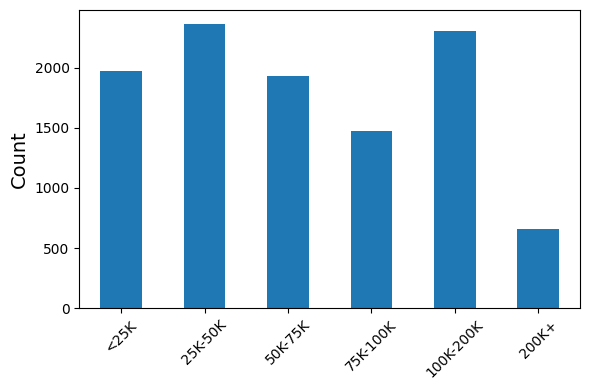

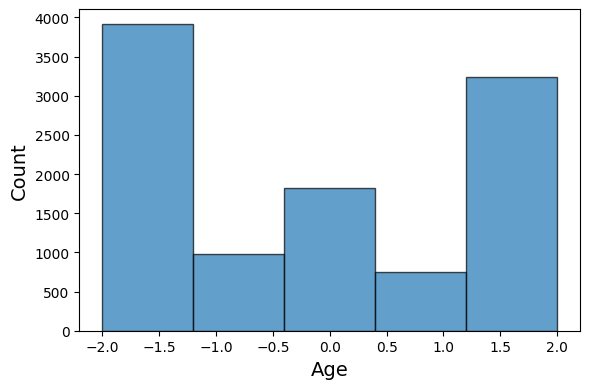

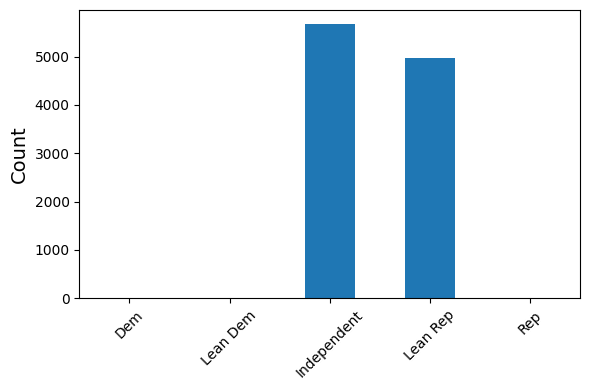

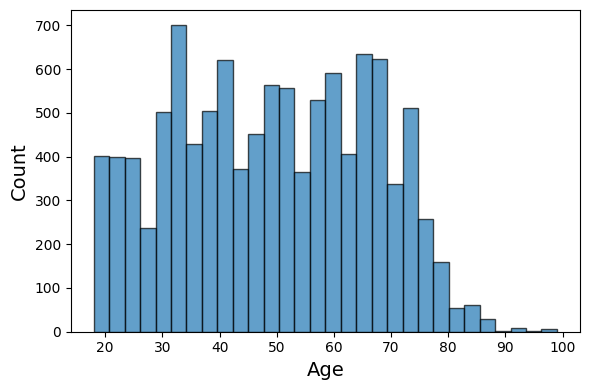

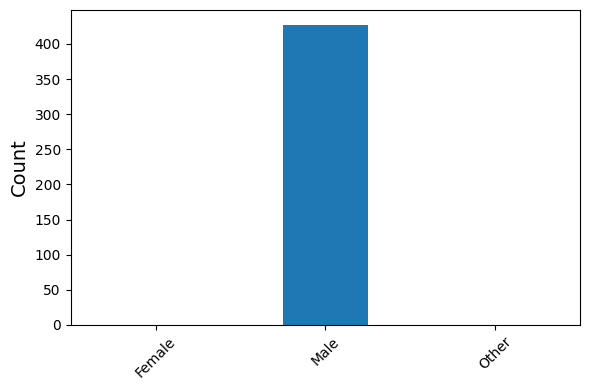

In [62]:
df_plot=df
#df_plot['pol_score'] = df_plot['pol_score'].astype('category')
columns_to_plot = ['dem_income','pol_score','dem_male','dem_age','dem_educ']
category_order=[[1,2,3,4,5,6],[-2,-1,0,1,2],[0,1,77],[1,2,3,4,5,6]]
category_labels=[['<25K','25K-50K','50K-75K','75K-100K','100K-200K','200K+'],['Dem','Lean Dem','Independent','Lean Rep','Rep'],['Female','Male','Other'],['upto HS','Diploma','Some College','Associate deg','Bachelors Deg','Advanced Deg']]
bins_list=[6,5,3,30,5]
c=0
for i,col in enumerate(columns_to_plot):
    plt.figure(figsize=(6, 4))
    col_data = df_plot[col]
    if pd.api.types.is_numeric_dtype(col_data):
        plt.hist(col_data.dropna(), bins=bins_list[i], edgecolor='black', alpha=0.7)
        #plt.xlabel(col,fontsize=14)
        plt.xlabel('Age',fontsize=14)
        plt.ylabel("Count",fontsize=14)
        #plt.title(f"Distribution of {col}")
    else:
        # Use value_counts with reindex to enforce the order
        col_counts = col_data.value_counts(dropna=False).reindex(category_order[c])
        col_counts.plot(kind='bar')
        #col_data.value_counts(dropna=False).plot(kind='bar')
        #plt.xlabel(col,fontsize=14)
        #plt.xticks(ticks=range(len(col_data)), labels=category_labels[c], rotation=45)
        tick_list = category_order[c]
        if tick_list[0] ==1:
            tick_list = [ii-1 for ii in tick_list]
        elif tick_list[0] < 0:
            tick_list = [0,1,2,3,4]
        else:
            tick_list = [0,1,2]
        plt.xticks(ticks=tick_list, labels=category_labels[c], rotation=45)
        plt.ylabel("Count",fontsize=14)
        plt.xlabel('')
        #plt.title(f"Distribution of {col}")
        c+=1
    plt.tight_layout()
    #plt.savefig(f"dist_{col}.png", dpi=400, bbox_inches='tight')
    plt.show()

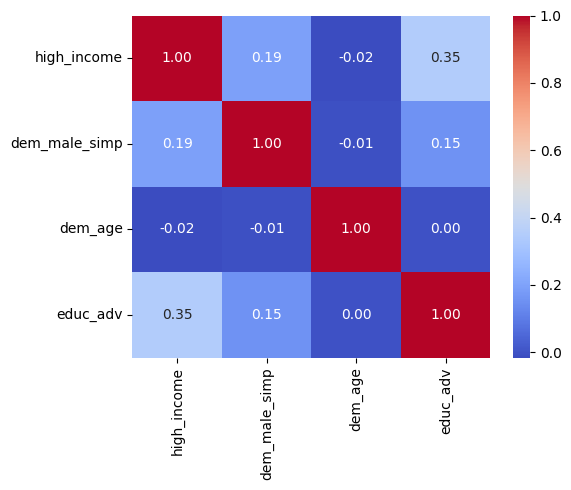

In [56]:
# Filter numeric and boolean columns from columns_to_check
numeric_cols = df[columns_to_check].select_dtypes(include=['number', 'bool']).columns

# Compute correlation matrix
corr_matrix = df[numeric_cols].astype(float).corr()

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
#plt.title("Correlation Matrix for Selected Columns")
plt.tight_layout()
#plt.savefig("correlation_matrix.png", dpi=400, bbox_inches='tight')
plt.show()

## Sampling from the surveyed population by selecting for demographic factors


In [ ]:
# Sample data based on weights for different town types

#university town

# df['weights'] = (
#     (df['dem_age'] < 35).astype(int) * 0.6 +
#     df['educ_adv'].astype(int) * 0.1 +
#     1e-2
# )

# rural conservative town

df['weights'] = (
    (df['pol_score'] > 0).astype(int) * 0.5 +
    #(df['educ_adv'] == False).astype(int) * 0.3 +
    (df['dem_age'] > 50).astype(int) * 0.3 +
    1e-2
)

sampled = df.sample(n=500, weights='weights', replace=True)


In [75]:
# Get distributions of all columns in the dataframe, handling numeric, boolean, and categorical/object types
columns_to_check = ['high_income','pol_score','dem_male_simp','dem_age','educ_adv']
for col in columns_to_check:
    print(f"\n--- Distribution for '{col}' ---")
    col_data = sampled[col]
    if pd.api.types.is_bool_dtype(col_data):
        print(col_data.value_counts(dropna=False))
    elif pd.api.types.is_numeric_dtype(col_data):
        print(col_data.describe())
    else:
        print(col_data.value_counts(dropna=False))


--- Distribution for 'high_income' ---
count    500.000000
mean       0.288000
std        0.453285
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: high_income, dtype: float64

--- Distribution for 'pol_score' ---
count    500.000000
mean       0.902000
std        1.586641
min       -2.000000
25%        0.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: pol_score, dtype: float64

--- Distribution for 'dem_male_simp' ---
count    500.000000
mean       0.432000
std        0.495851
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: dem_male_simp, dtype: float64

--- Distribution for 'dem_age' ---
count    500.000000
mean      56.974000
std       15.129677
min       18.000000
25%       50.000000
50%       60.000000
75%       68.000000
max       87.000000
Name: dem_age, dtype: float64

--- Distribution for 'educ_adv' ---
count    500.000000
mean       0.12

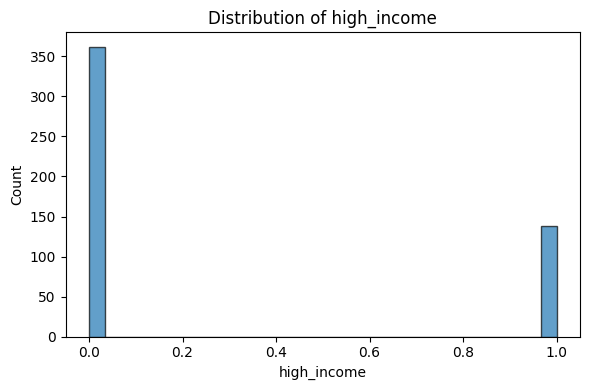

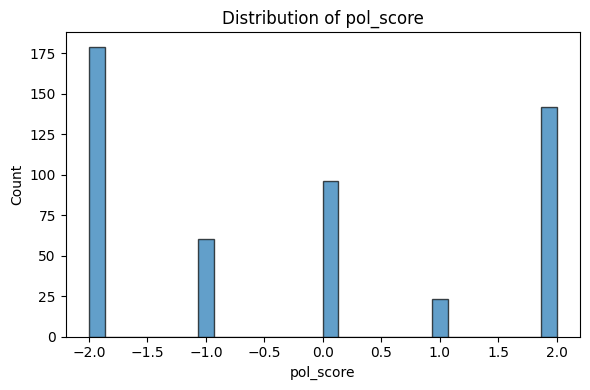

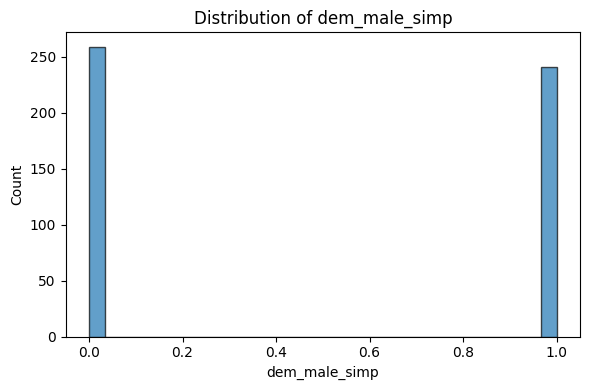

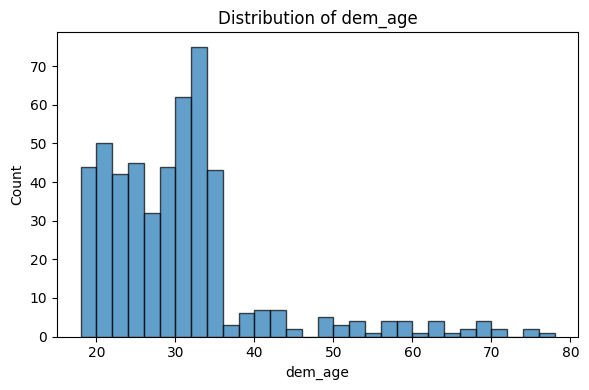

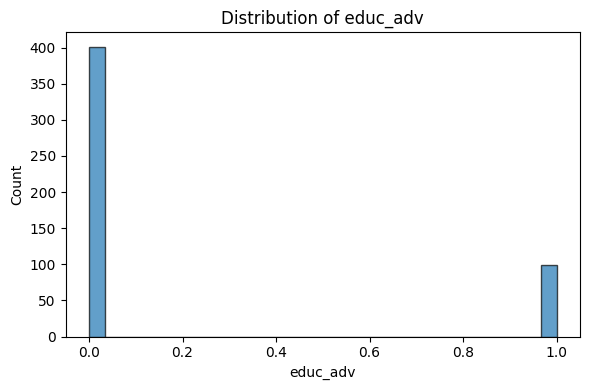

In [71]:
for col in columns_to_check:
    plt.figure(figsize=(6, 4))
    col_data = sampled[col]
    if pd.api.types.is_numeric_dtype(col_data):
        plt.hist(col_data.dropna(), bins=30, edgecolor='black', alpha=0.7)
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.title(f"Distribution of {col}")
    else:
        col_data.value_counts(dropna=False).plot(kind='bar')
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

In [171]:
#print(sampled.head())

# Compute break-even cost for the sampled profiles

In [76]:

# Load posterior ONCE outside the function
post = az.from_netcdf("signlogCost_full.nc").posterior

# with open('df_ccsolve_analysis.pkl', 'rb') as f:
#     dataframe = pickle.load(f)
dataframe=sampled
# Redefine the row-wise function using the preloaded `post`
def compute_break_even_for_row_joblib(row):
    profile = {
        "high_income[1]": row["high_income"],
        "pol_score": row["pol_score"],
        "dem_male_simp[True]": int(row["dem_male_simp"]),
        "dem_age": row["dem_age"],
        "educ_adv[True]": int(row["educ_adv"])
    }
    df_cost = break_even_cost(profile, post=post)
    return df_cost["cost_star"].median()

# Convert to list of dicts (records) for joblib-friendly input
rows = dataframe.to_dict(orient="records")

# Run in parallel using joblib with 16 workers
results = Parallel(n_jobs=16, backend="loky")(
    delayed(compute_break_even_for_row_joblib)(row) for row in rows
)

# Assign results back to DataFrame
dataframe["break_even_cost_median"] = results

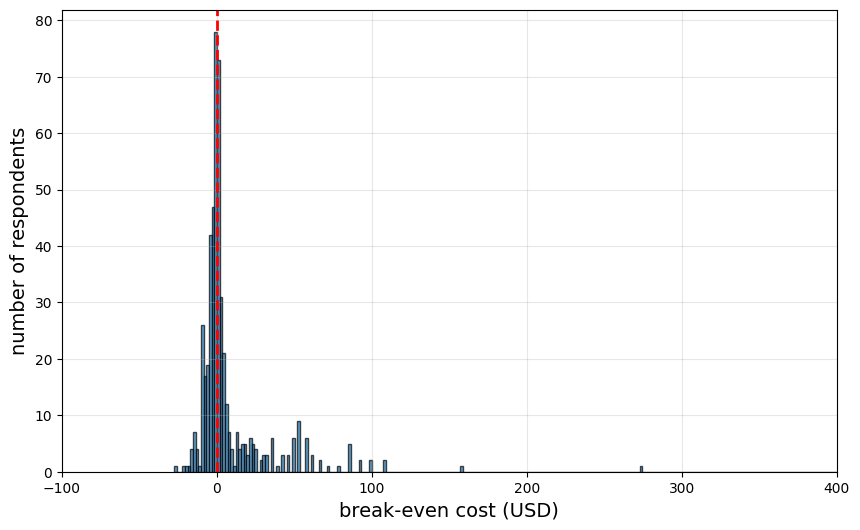

median value: 0.11055649858351074
mean value: 8.359751036457542


In [77]:
plt.figure(figsize=(10, 6))
median_value = dataframe["break_even_cost_median"].median()
mean_value=dataframe["break_even_cost_median"].mean()
plt.hist(dataframe["break_even_cost_median"], bins=250, edgecolor='black', alpha=0.7)
plt.axvline(median_value, color='red', linestyle='dashed', linewidth=2)
#plt.title("histogram of break-even Costs", fontsize=16)
plt.xlabel("break-even cost (USD)", fontsize=14)
plt.ylabel("number of respondents", fontsize=14)
plt.grid(alpha=0.3)
plt.xlim(-100, 400)
#plt.title("Histogram of Break-even Costs(university town)", fontsize=16)
#plt.savefig("histogram_conserveative_town.png", dpi=400, bbox_inches='tight')
plt.show()
print(f"median value: {median_value}")
print(f"mean value: {mean_value}")


# Generating homphilic networks based on SDA 

In [28]:
def preferential_sda_network(
    df,
    features,
    feature_weights=None,
    m=3,
    alpha=2.0,
    b=0.5,
    scale_features=True,
    seed_size=None,
    use_degree=True
):
    """
    Builds a network where each new node forms m connections based on
    SDA-inspired homophily and optionally degree-based preferential attachment.

    Parameters:
    - df: DataFrame of individuals
    - features: list of column names to use for similarity
    - feature_weights: dict of relative feature importance
    - m: number of edges added per new node
    - alpha: homophily strength in SDA probability function
    - b: scale parameter in SDA function
    - scale_features: whether to normalize features to [0, 1]
    - seed_size: initial graph size (default = m + 1)
    - use_degree: if True, multiply SDA probability by node degree

    Returns:
    - G: networkx.Graph
    """
    N = len(df)
    if seed_size is None:
        seed_size = m + 1

    # Prepare feature matrix
    X = df[features].copy()
    X.columns = [str(c) for c in X.columns]

    for col in X.select_dtypes('bool').columns:
        X[col] = X[col].astype(int)

    if scale_features:
        scaler = MinMaxScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    if feature_weights is None:
        feature_weights = {f: 1.0 for f in features}
    else:
        feature_weights = {k: v / sum(feature_weights.values()) for k, v in feature_weights.items()}

    # Apply feature weights
    for f in features:
        X[f] *= feature_weights.get(f, 0)

    # Start with complete graph
    G = nx.complete_graph(seed_size)

    for new_node in range(seed_size, N):
        existing_nodes = list(G.nodes)
        x_new = X.iloc[new_node].values.reshape(1, -1)
        x_existing = X.iloc[existing_nodes].values

        # Compute Euclidean distance
        dists = distance.cdist(x_new, x_existing, metric='euclidean').flatten()

        # SDA-inspired connection probabilities
        sda_prob = 1 / (1 + (dists / b) ** alpha)

        # Multiply by degree if requested
        if use_degree:
            degrees = np.array([G.degree(j) for j in existing_nodes])
            sda_prob *= (degrees + 1e-6)

        sda_prob = np.nan_to_num(sda_prob, nan=0.0, posinf=0.0, neginf=0.0)
        if sda_prob.sum() == 0:
            probs = np.ones_like(sda_prob) / len(sda_prob)
        else:
            probs = sda_prob / sda_prob.sum()

        # Sample m unique targets
        targets = np.random.choice(existing_nodes, size=m, replace=False, p=probs)
        for t in targets:
            G.add_edge(new_node, t)

    return G


In [ ]:
#selecting features and weights for the network
features = ['log_income_median', 'dem_educ', 'dem_age', 'pol_score']
feature_weights = {
    'log_income_median': 0.0,
    'dem_educ': 0.25,
    'dem_age': 0.25,
    'pol_score': 0.5  # most important
}


G = preferential_sda_network(
    df=dataframe,
    features=features,
    feature_weights=feature_weights,
    m=10,
    alpha=2.0,   # steeper decay with distance
    b=0.01,       # more localized connections
    use_degree=False
)

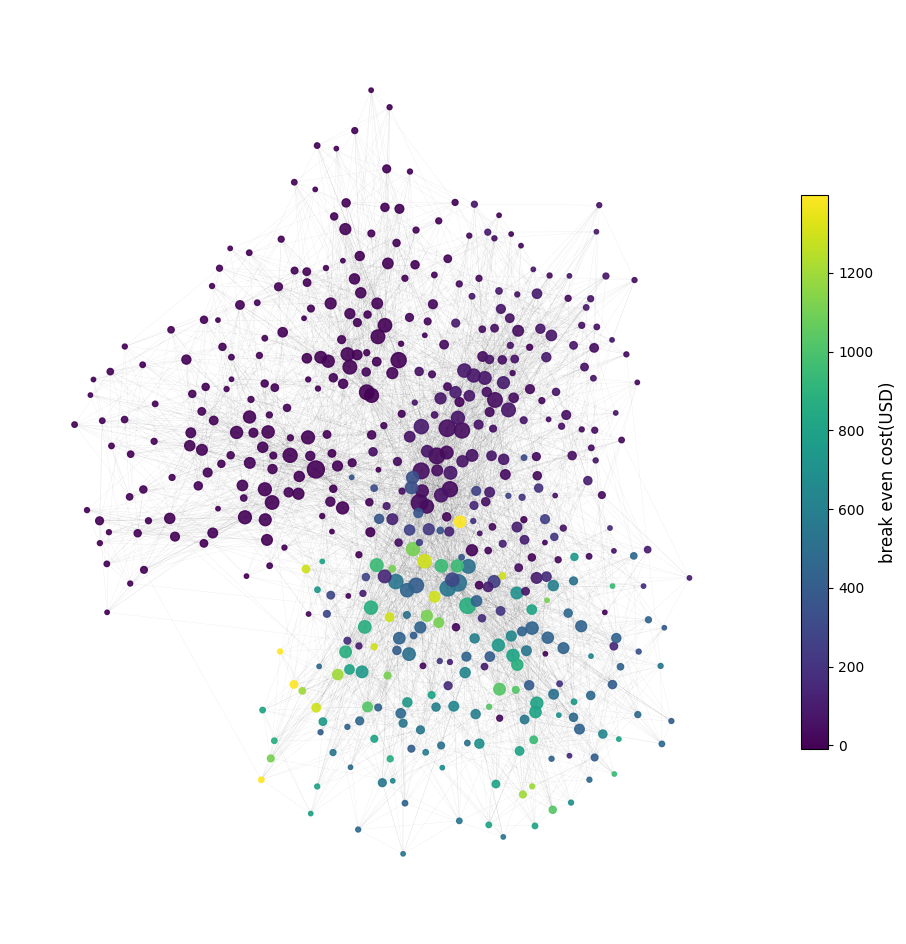

In [49]:
color_feature = 'break_even_cost_median'
node_values = dataframe.iloc[list(G.nodes)][color_feature]
#node_values=np.log(node_values+10)

# Normalize values for colormap
norm = mcolors.Normalize(vmin=node_values.min(), vmax=node_values.max())
cmap = cm.viridis
#cmap=cm.bwr_r
node_colors = cmap(norm(node_values))

# ---- Node size based on degree ----
degrees = dict(G.degree())
degree_values = np.array([degrees[n] for n in G.nodes()])
# Rescale degree to reasonable visual size
min_size, max_size = 10, 150
degree_scaled = min_size + (degree_values - degree_values.min()) / (np.ptp(degree_values)) * (max_size - min_size)

# ---- Plotting ----
fig, ax = plt.subplots(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.2, iterations=100, seed=42)
#pos = nx.kamada_kawai_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=degree_scaled, node_color=node_colors, alpha=0.9, ax=ax)
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.1, ax=ax)

#ax.set_title(f"University town network Colored by {color_feature}")
#ax.set_title(f"Conservative rural town network ")
ax.axis('off')

# Colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(node_values)
cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
cbar.set_label('break even cost(USD)', fontsize=12)

#fig.savefig("network_university_town.png", dpi=400, bbox_inches='tight')

plt.show()

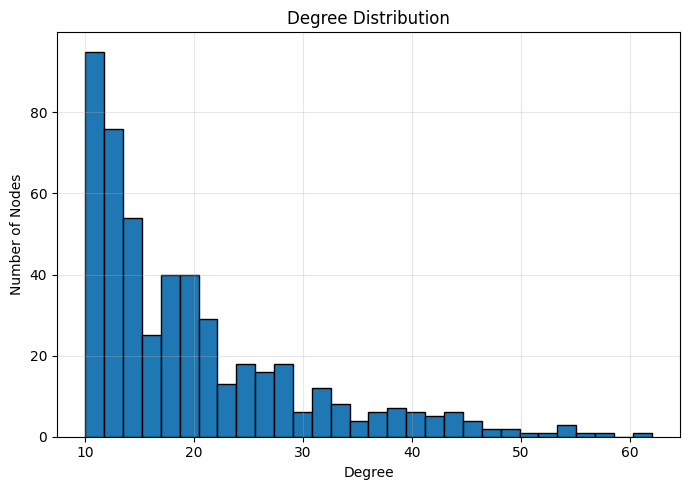

Average degree: 19.78


In [366]:
degrees = [d for _, d in G.degree()]
plt.figure(figsize=(7, 5))
plt.hist(degrees, bins=30, edgecolor='black')
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.title("Degree Distribution")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print(f"Average degree: {np.mean(degrees):.2f}")